# Numerical Summaries of Data

Congratulations, you have some data. Now what? Well, ideally, you'll have a research question to match. In practice, that's not always true or even possible. 
So, in the following tutorial, we're going to present some methods to explore your data, using an example data set from SDSS. Most of these methods focus on *summarizing* the data in some way, that is, compress the information in your data set in such a way that it will be more useful to you than the raw data. There are many ways to achieve this sort of compression; we'll only showcase a few of them. In general, one can summarize data numerically, that is, compute a set of numbers that describe the data in a meaningful way that trades loss of information with descriptiveness. One can also summarize data sets visually, in the form of graphs. Here, we will explore the former category (although we won't get away without making any graphs here, either!). The following tutorial will explore visual summaries of data in more detail.

Many of these methods may seem familiar, but we'll try to teach you something new, too! 
At the same time, you'll also get to know some of the most useful packages for numerical computation in python: numpy and scipy.

Before we start, let's load some astronomy data!

In [1]:
import os
import requests 

# get some CSV data from the SDSS SQL server
URL = "http://skyserver.sdss.org/dr12/en/tools/search/x_sql.aspx"

cmd = """
SELECT TOP 10000
    p.u, p.g, p.r, p.i, p.z, s.class, s.z, s.zerr
FROM
    PhotoObj AS p
JOIN
    SpecObj AS s ON s.bestobjid = p.objid
WHERE
    p.u BETWEEN 0 AND 19.6 AND
    p.g BETWEEN 0 AND 20 AND
    (s.class = 'STAR' OR s.class = 'GALAXY' OR s.class = 'QSO')
"""
if not os.path.exists('all_colors.csv'):
    cmd = ' '.join(map(lambda x: x.strip(), cmd.split('\n')))
    response = requests.get(URL, params={'cmd': cmd, 'format':'csv'})
    with open('all_colors.csv', 'w') as f:
        f.write(response.text)

In [2]:
import pandas as pd
df = pd.read_csv("all_colors.csv",skiprows=1)

In [3]:
df.head()

,u,g,r,i,z,class,z1,zerr
0,19.16978,17.08930,16.04692,15.55223,15.17684,GALAXY,0.076246,0.000019
1,18.88655,17.26482,16.53105,16.23936,16.05161,STAR,0.000122,0.000009
2,18.94358,17.47576,16.79267,16.49504,16.30348,STAR,0.000161,0.000011
3,18.42756,16.98290,16.79660,16.78195,16.72049,STAR,0.000123,0.000010
4,18.76420,16.92113,16.04104,15.65526,15.39297,STAR,0.000241,0.000008


## Summarizing Data

There are a few very simple, but often used ways to summarize data: the arithmetic mean and median, along the standard deviation, variance or standard error. For a first look at what your data looks like, these can be incredibly useful tools, but be aware of their limitations, too!

The arithmetic mean of a (univariate) sample $x = \{x_1, x_2, ..., x_n\}$ with n elements is defined as 

$\bar{x} = \frac{1}{n}\sum_{i=1}^{n}{x_i}$  .

In python, you can of course define your own function to do this, but much faster is the implementation in numpy:

In [4]:
import numpy as np

galaxies = df[df["class"]=="GALAXY"]
x = np.array(galaxies["r"])

x_mean = np.mean(x)

print("The mean of the r-band magnitude of the galaxies in the sample is %.3f"%x_mean)


The mean of the r-band magnitude of the galaxies in the sample is 16.651


`numpy` also has the `average` function, which allows for a *weighted* average, unlike `mean`:

In [6]:
x_avg = np.average(x,weights=np.random.uniform(0,1,size=x.shape[0]))
print("The weighted average is " + str(x_avg))

The weighted average is 16.6629131757


Note that if you have multivariate data (i.e. several dimensions), you can use the `axis` keyword to specify which dimension to average over:

In [7]:
x_multi = np.array(galaxies[["u", "g", "r"]])
print(x.shape)

(4299,)


In [8]:
## global average
print(np.mean(x_multi))

## average over the sample for each colour
print(np.mean(x_multi, axis=0))

## average over all colours for each galaxy in the sample
print(np.mean(x_multi, axis=1))

17.6026387927
[ 18.80438917  17.35221503  16.65131218]
[ 17.43533333  16.05213667  18.12191667 ...,  17.50825667  18.4525
  18.01905333]


Note: which dimension you want to average over depends on the shape of your array, so be careful (and check the shape of the output, if in doubt!).

The average is nice to have, since it's a measure for the "center of gravity" of your sample, however, it is also prone to be strongly affected by outliers! In some cases, the **median**, the middle of the sample, can be a better choice. For a sample of length $n$, the median is either the $(n+1)/2$-th value, if $n$ is odd, or the mean of the middle two values $n/2$ and $(n+1)/2$, if $n$ is even. 
Again, numpy allows for easy and quick computation:

In [9]:
x_med = np.median(x)
print("The median of the r-band magnitude of the sample of galaxies is %.3f"%x_med)

The median of the r-band magnitude of the sample of galaxies is 16.756


Both the median and mean are useful, but be aware that unless the underlying distribution that created your sample is symmetric: 

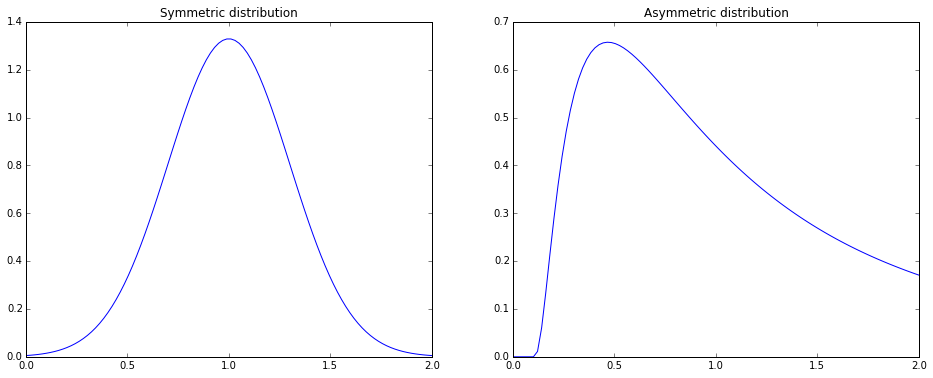

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
xcoord = np.linspace(0,2,100)
ax1.plot(xcoord, scipy.stats.norm(1.0, 0.3).pdf(xcoord))
ax1.set_title("Symmetric distribution")
ax2.plot(xcoord, scipy.stats.lognorm(1.0, 0.1).pdf(xcoord))
ax2.set_title("Asymmetric distribution")

For a (large enough) sample drawn from the distribution the mean and median will not be the same, and more importantly, in this case, they will also **not** be equal to the most probable value (the top of the distribution). The latter is also called the **mode**. There's no intrinsic nifty way to compute the mode of a distribution (or sample). In practice, for a univariate sample, you might make a **histogram** of the sample (that is, define finite bins over the width of your sample, and count all elements that fall into each bin), and then find the bin with the most counts. Note that for creating a histogram, you need to pick the number of your bins (or, equivalently, the width of each bin). This can be tricky, as we'll discuss in more detail in the visualization part of this tutorial. 


In [11]:
h, edges = np.histogram(x, bins=30,range=[16.,19.6], normed=False)

In [12]:
## find the index where the binned counts have their maximum
h_max = np.where(h == np.max(h))[0]

## these are the maximum binned counts
max_counts = h[h_max]

## find the middle of the bin with the maximum counts
edge_min = edges[h_max]
edge_max = edges[h_max+1]
edge_mean = np.mean([edge_min, edge_max])

print("The mode of the distribution is located at %.4f"%edge_mean)

The mode of the distribution is located at 17.0200


Mean, median and mode all tell us something about the center of the sample. However, it tells us nothing about the spread of the sample: are most values close to the mean (high precision) or are they scattered very far (low precision)?

For this, we can use the variance, the squared deviations from the mean:

$s^2_x = \frac{1}{n-1}\sum_{i=1}^{n}{(x_i - \bar{x})^2}$

or its square root, the standard deviation: $s_x = \sqrt{s^2_x}$.

Similarly to the mean, there are functions in numpy for the mean and the standard deviation, and again, it is possible to specify the axis along which to compute either:

In [13]:
x_var = np.var(x, ddof=1)
x_std = np.std(x, ddof=1)

print("The variance of the r-band magnitude for the galaxies in the sample is %.4f"%x_var)
print("The standard deviation of the r-band magnitude for the galaxies in the sample is %.4f"%x_std)

x_var_multi = np.var(x_multi, axis=0, ddof=1)
x_std_multi = np.std(x_multi, axis=0, ddof=1)

print("The variance of the for all three bands for the galaxies in the sample is "+str(x_var_multi))
print("The standard deviation for all three bands for the galaxies in the sample is " + str(x_std_multi))


The variance of the r-band magnitude for the galaxies in the sample is 0.7827
The standard deviation of the r-band magnitude for the galaxies in the sample is 0.8847
The variance of the for all three bands for the galaxies in the sample is [ 0.52938372  0.63016432  0.78268418]
The standard deviation for all three bands for the galaxies in the sample is [ 0.7275876  0.7938289  0.8846944]


**Note**: If your data set contains NaN values, you can use the functions `nanmean`, `nanvar` and `nanstd` instead, which will compute the mean, variance and standard deviation, respectively, while ignoring any NaN values in your data.

What is the error on the mean? That depends on the size of your sample! Imagine you pick many samples from the population of possible outcomes. If each sample has a large number of elements, then you are more likely to find similar means for each of your samples than if the sample size is small. 

Given that we might not have many samples from the population (but perhaps only one SDSS data set!), we'd like to quantify how well we can specify the mean. We do this by dividing the variance by the number of data points and taking the square root to get the **standard error**:

In [14]:
se = np.sqrt(np.var(x)/x.shape[0])
print("The standard error on the mean for the r-band galaxy magnitudes is %.4f"%se)

The standard error on the mean for the r-band galaxy magnitudes is 0.0135


Mean and variance give us general information about the center and the spread of the sample, but tell us nothing about the shape. 

If we want yet more information about how the data are distributed, we'll have to introduce yet another concept: the **quantile** the $\alpha$-quantile of a sample is the point below which a fraction $\alpha$ of the data occur. 
For example, the $0.25$-quantile is the point below which $25\%$ of the sample is located. Note that the 0.5-quantile is the median. 

The 0.25, 0.5 and 0.75 quantiles are also called the first, second and third quantile, respectively. The difference between the 0.25 and 0.75 quantile are called the **interquartile range** (remember that! We'll come back to it!).

Both `numpy` and `scipy` have code for this:

In [17]:
from scipy.stats.mstats import mquantiles

q = np.percentile(x, [25., 50., 75.])
print("The 0.25 percentile is " + str(q))

q = mquantiles(x, prob=[0.25, 0.5, 0.75])
print("The 0.25, 0.5 and 0.75 of the r-band galaxy magnitudes are " + str(q))

The 0.25 percentile is [ 16.183965  16.75585   17.298085]
The 0.25, 0.5 and 0.75 of the r-band galaxy magnitudes are [ 16.182876  16.75585   17.29843 ]


Using this, we can now compute the Tukey five-number summary: a collection of five numbers that contains first quartil, median, second quartile as well as the minimum and maximum values in the sample. Together, they give a reasonably good first impression of how the data are distributed:

In [19]:
def tukey_five_number(x):
    x_min = np.min(x)
    x_max = np.max(x)
    q = mquantiles(x, prob=[0.25, 0.5, 0.75])
    return np.hstack([x_min, q, x_max])

In [20]:
print("The Tukey five-number summary of the galaxy r-band magnitudes is: " + str(tukey_five_number(x)))

The Tukey five-number summary of the galaxy r-band magnitudes is: [ 11.62901   16.182876  16.75585   17.29843   24.80204 ]


Finally, if you're working with a pandas DataFrame, you can use the method `describe` to print some statistical summaries as well:

In [21]:
df.describe()

,u,g,r,i,z,z1,zerr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.544234,17.250815,16.713258,16.466774,16.309103,0.124569,0.060707
std,0.907272,1.032828,1.152263,1.212772,1.286174,0.396333,4.647630
min,11.960040,11.688460,11.271150,11.048570,10.629170,-0.002965,-4.000000
25%,18.080027,16.666845,16.043048,15.749308,15.533058,0.000080,0.000008
50%,18.792405,17.414145,16.785750,16.507530,16.331530,0.001224,0.000010
75%,19.239483,17.955283,17.462840,17.208642,17.096488,0.083216,0.000016
max,19.599920,19.920830,24.802040,28.182330,22.826920,5.854882,429.914900


Let's think more about the mean of a sample. Imagine we actually have a reasonably good idea of what the mean should be. We might then want to ask whether the sample we collected is consistent with that predetermined theoretical value. To do that, we can take the difference between the sample mean and the theoretical value, but we'll need to normalize it by the standard error. After all, the sample mean could be far from the theoretical prediction, but if the spread in the sample is large, that might not mean much.

$t = \frac{\bar{x} - \mu}{\sqrt{(s_x^2/n)}}$

This number is also called the **Student t-statistic** for univariate data.

This is, of course, not hard to write down in python with the functions for mean and variance we've learned above, but as above, we can make use of functionality in scipy to achieve the same result:

In [22]:
import scipy.stats

## some theoretical prediction
mu = 16.8

## compute the t-statistic.
t = scipy.stats.ttest_1samp(x, mu)

t_statistic = t.statistic
p_value = t.pvalue

print("The t-statistic for the galaxy r-band magnitude is %.4f"%t_statistic)
print("The p-value for that t-statistic is " + str(p_value))

The t-statistic for the galaxy r-band magnitude is -11.0196
The p-value for that t-statistic is 7.23412760149e-28


** need to write some explanation here **

## Statistical Distributions in scipy

Aside from the two examples above, `scipy.stats` has a large amount of functionality that can be helpful when exploring data sets. 

We will not go into the theory of probabilities and probability distributions here. Some of that, you will learn later this week. But before we start, some definitions:

* **random variable**: technically, a function that maps sample space (e.g. "red", "green", "blue") of some process onto real numbers (e.g. 1, 2, 3)
* we will distinguish between **continuous** random variables (which can take all real values in the *support* of the distribution) and **discrete** random variables (which may only take certain values, e.g. integers).
* the **probability mass function (PMF)** for discrete variables maps the probability of a certain outcome to that outcome
* in analogy, the **probability density function (PDF)** for continuous random variables is the probability mass in an interval, divided by the size of that interval (in the limit of the interval size going to zero)
* the **cumulative distribution function (CDF)** at a point x of a distribution is the probability of a random variable X being smaller than x: it translates to the integral (sum) over the PDF (PMF) from negative infinity up to that point x for a continuous (discrete) distribution. 

`scipy.stats` defines a large number of both discrete and continuous probability distributions that will likely satisfy most of your requirements. For example, let's define a standard normal distribution.

In [23]:
## continuous (normal) distribution

loc = 2.0
scale = 0.4 

dist = scipy.stats.norm(loc=loc, scale=scale)
dist

We've now created an object that defines a normal (Gaussian) distribution with a scale parameter of 0.4 and a center of 2. What can we do with this?

For example, draw a random sample:

In [24]:
s = dist.rvs(100)
print(s)

[ 2.36603312  1.68700654  1.56394086  2.2335101   1.52665354  1.81081913
  2.3791721   1.53585893  2.20858649  2.00579709  1.51404283  2.04298998
  2.73305471  2.02684907  2.07985515  1.6478574   1.77354211  1.95574797
  1.98669179  1.94192248  1.62290398  2.0755477   1.53503487  2.43681671
  1.9523593   1.96306728  1.79425405  2.19933483  1.998277    2.0490028
  2.72069636  1.51760875  2.24221723  1.69389025  1.72143474  2.02398266
  1.73088222  2.2179496   1.19867523  1.77601824  2.52611391  1.68589427
  1.93912064  2.11413104  2.27934766  2.16305826  2.77135833  2.02802486
  1.34326845  2.01148234  1.34703916  1.56163122  2.83920546  2.13092276
  1.80314617  1.88630428  1.98396517  1.35432028  2.17241956  1.6889193
  2.73955644  2.5406693   1.96314476  2.36216915  2.24972964  1.56163592
  1.65647943  1.91307563  1.89327545  1.67112332  2.1110905   1.59228851
  2.7816415   1.93775204  2.38297551  1.87937366  1.79117229  2.05065605
  2.2867847   1.70678231  2.05691272  1.54648548  2.1

We have sampled 100 numbers from that distribution!

We can also compute the PDF in a given range:

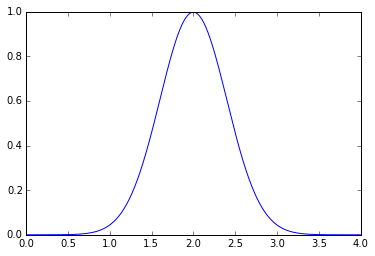

In [25]:
xcoord = np.linspace(0,4,500)
pdf = dist.pdf(xcoord)

plt.plot(xcoord, pdf)

or the CDF:

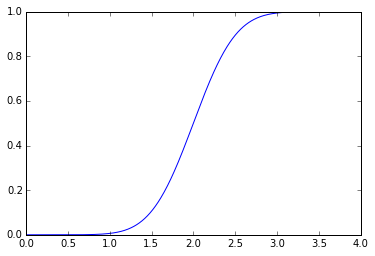

In [26]:
cdf = dist.cdf(xcoord)

plt.plot(xcoord, cdf)

Mean, median, var and std work as methods for the distribution, too:

In [27]:
print("distribution mean %.4f"%dist.mean())
print("distribution median %.4f"%dist.median())
print("distribution standard deviation %.4f"%dist.std())
print("distribution variance %.4f"%dist.var())


distribution mean 2.0000
distribution median 2.0000
distribution standard deviation 0.4000
distribution variance 0.1600


Easier than that, we can get it to just give us the moments of the distribution: the mean, the variance, the skewness and the kurtosis (below, replace 'mvsk' by any combination of those four letters to get it to print any of the four):

In [28]:
dist.stats(moments='mvsk')

(array(2.0), array(0.16000000000000003), array(0.0), array(0.0))

For computing the $n$th-order non-central moment, use the `moment` method:

In [29]:
dist.moment(1)

2.0

For more advanced purposes, we can also compute the survival function (1-CDF) and the percent point function (1/CDF) of the distribution:

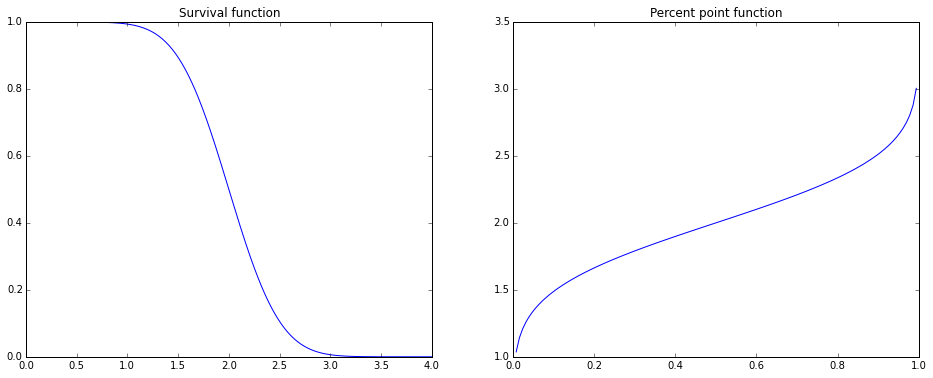

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(xcoord, dist.sf(xcoord))
ax1.set_title("Survival function")

ax2.plot(xcoord, dist.ppf(xcoord))
ax2.set_title("Percent point function")

To compute a confidence interval around the median of the distribution, use the method `interval`:

In [31]:
dist.interval(0.6)

(1.6633515065708342, 2.3366484934291658)

To find the support of a distribution, you can use `interval`: the support is the interval under which the integrated probability is 1:

In [32]:
dist.interval(1.0)

(-inf, inf)

Finally, if you have some data that you think was drawn from the distribution, you may use the `fit` method to fit the distribution's parameters to the sample:

In [33]:
normal_data = np.random.normal(4.0, 0.2, size=1000)

data_loc, data_scale = scipy.stats.norm.fit(normal_data)
print("the location and scale parameters of the fit distribution are %.3f and %.3f, respectively."%(data_loc, data_scale))

the location and scale parameters of the fit distribution are 3.994 and 0.200, respectively.


Discrete distributions function in exactly the same way, except that instead of a `pdf` method, they will have a `pmf` method:

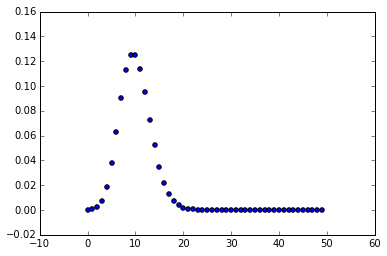

In [34]:
## set the distribution
dist = scipy.stats.poisson(10)

## make an x-coordinate: Poisson distribution only defined
## for positive integer numbers!
xcoord = np.arange(0,50,1.0)

## plot the results
plt.scatter(xcoord, dist.pmf(xcoord))

**Exercise**: Take the galaxy data we've used above and fit a distribution of your choice (see http://docs.scipy.org/doc/scipy/reference/stats.html for a list of all of them) and compare the parameters of your distribution to the sample mean and variance (if they're comparable.

### Multivariate data

Of course, most data sets aren't univariate. As we've seen above, we can use the same functions that we've used to compute  mean, median, variance and standard deviation for multi-variate data sets in the same way as for single-valued data, except that we need to specify the axis along which to compute the operation. 

However, these functions will compute the mean, variance etc. for each dimension in the data set *independently*. This unfortunately tells us nothing about whether the data vary with each other, that is, whether they are correlated in any way. One way to look at whether data vary with each other is by computing the covariance. Let's take our slightly expanded galaxy data set (with three colours from above, and compute the covariance between the three magnitude bands.

Because of the way I've set up the array above, we need to take the transpose of it in order to get the covariance between the bands (and not between the samples!). 

In [35]:
cov = np.cov(x_multi.T)
print(cov)

[[ 0.52938372  0.51149323  0.48624376]
 [ 0.51149323  0.63016432  0.67565774]
 [ 0.48624376  0.67565774  0.78268418]]


Note that the matrix is symmetric about the diagonal. Also, the values on the diagonal are just the variance:

In [36]:
x_var = np.var(x_multi, axis=0, ddof=1)
print(x_var)
x_var_cov = np.diag(cov)
print(x_var_cov)

[ 0.52938372  0.63016432  0.78268418]
[ 0.52938372  0.63016432  0.78268418]


To compute the actual correlation between two samples, compute the correlation coefficient, which is the ratio of sample covariance and the product of the individual standard deviations:

$s_{xy} = \frac{1}{n-1}\sum{(x_i - \bar{x})(y_i - \bar{y})}$ ;

$r = \frac{s_{xy}}{s_x s_y}$

In [37]:
r = np.corrcoef(x_multi.T)
print(r)

[[ 1.          0.88557979  0.75539737]
 [ 0.88557979  1.          0.96206977]
 [ 0.75539737  0.96206977  1.        ]]


The correlation coefficient can range between -1 and 1. If two samples are only offset by a scaling factor (perfect correlation), then $r = 1$. $r = 0$ implies that there is no correlation.

Another way to compare two samples is to compare the *means* of the two samples. To do this, we can use a generalization of the Student's t-test above to higher dimensions for two samples $x$ and $y$:

$t = \frac{\bar{x} - \bar{y}}{\sqrt{\left(\frac{s_x^2}{n} + \frac{s_y^2}{n}\right)}}$.

In python: 

In [38]:
t = scipy.stats.ttest_ind(x_multi[:,0], x_multi[:,1])
t_stat = t.statistic
t_pvalue = t.pvalue

print("The t-statistic for the two bands is %.4f"%t_stat)
print("The p-value for that t-statistic is " + str(t_pvalue))

The t-statistic for the two bands is 88.4215
The p-value for that t-statistic is 0.0


Note that the t-statistic tests whether the *means* of the two samples are the same. We can also test whether a sample is likely to be produced by a reference distribution (single-sample Kolmogorov-Smirnov test) or whether two samples are produced by the same, underlying (unknown) distribution (2-sample Kolmogorov-Smirnov test).

The one-sample  KS-test (test sample against a reference distribution) can take, for example, the `cdf` method of any of the distributions defined in scipy.stats. 

In [39]:
ks = scipy.stats.kstest(x, scipy.stats.norm(np.mean(x), np.var(x)).cdf)
print("The KS statistic for the sample and a normal distribution is " + str(ks.statistic))
print("The corresponding p-value is " + str(ks.pvalue))

The KS statistic for the sample and a normal distribution is 0.0689309216324
The corresponding p-value is 3.62017717266e-18


Analogously, for the 2-sample KS-test:

In [40]:
ks = scipy.stats.ks_2samp(x_multi[:,0], x_multi[:,1])
print("The KS statistic for the u and g-band magnitudes is " + str(ks.statistic))
print("The corresponding p-value is " + str(ks.pvalue))

The KS statistic for the u and g-band magnitudes is 0.76366596883
The corresponding p-value is 0.0


There are *many* more statistical tests to compare distributions and samples, too many to showcase them all here. Some of them are implemented in scipy.stats, so I invite you to look there for your favourite test!

### Linear Regression

Perhaps you've found a high correlation coefficient in your data. Perhaps you already expect some kind of functional dependence of your (bivariate) data set. 
In this case, linear regression comes in handy. Here, we'll only give a *very* brief overview of how to do it (and introduce you to scipy.optimize). Later in the week, you'll learn how to do parameter estimation properly.

Doing simple linear regression in python requires two steps: one, you need a linear (in the coefficients) model, and a way to optimize the parameters with respect to the data. 
Here's where scipy.optimize comes in really handy. But first, let's build a model:

In [41]:
def straight(x, a, b):
    return a*x+b

Now we'll take two variables, in this case the g- and the r-band magnitudes, and use `curve_fit` from scipy.optimize to do linear regression:

In [42]:
import scipy.optimize 

x = np.array(galaxies["r"])
y = np.array(galaxies["g"])

popt, pcov = scipy.optimize.curve_fit(straight, x, y, p0=[1.,2.])

`curve_fit` returns first the best-fit parameters, and also the covariance matrix of the parameters:

In [43]:
print("The best fit slope and intercept are " + str(popt))
print("The covariance matrix of slope and intercept is " + str(pcov))

The best fit slope and intercept are [ 0.86325717  2.97785033]
The covariance matrix of slope and intercept is [[  1.39444634e-05  -2.32193615e-04]
 [ -2.32193615e-04   3.87723998e-03]]


Let's plot this to see how well our model's done!

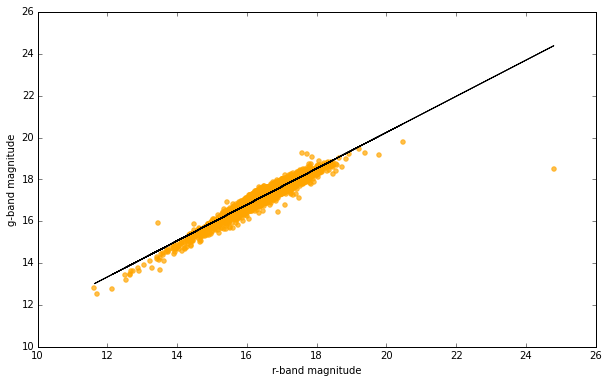

In [44]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(x,y, color="orange", alpha=0.7)
ax.plot(x, straight(x, *popt), color="black")
ax.set_xlabel("r-band magnitude")
ax.set_ylabel("g-band magnitude")

Note that standard linear regression assumes a model that's strictly linear in the coefficients (that is, for example a power law of the type $f(x) = ax^b$ wouldn't be), as well as errors on the data that are independent and identically distributed (they are *homoscedastic*), `curve_fit` allows for non-linear models as well as *heteroscedastic* errors:

In [45]:
## make up some heteroscedastic errors:
yerr = np.random.normal(size=y.shape[0])*y/10.

popt, pcov = scipy.optimize.curve_fit(straight, x, y, sigma=yerr)

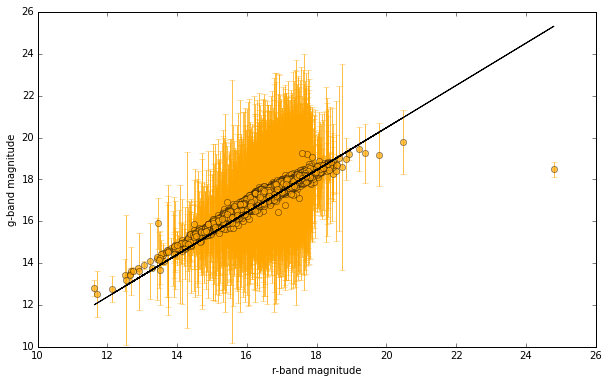

In [46]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.errorbar(x,y, fmt="o", yerr=yerr, color="orange", alpha=0.7)
ax.plot(x, straight(x, *popt), color="black")
ax.set_xlabel("r-band magnitude")
ax.set_ylabel("g-band magnitude")

The errors that I made up for the example above depend on the value of each data point. Therefore, for a higher r-band magnitude, the error will be larger, too. 

Note that `curve_fit` still assumes your measurement errors are Gaussian, which will allow you to use (generalized) least-squares to do the optimization. If this is not true, you will need to define your own *likelihood*. The likelihood is the probability of obtaining a data set under the assumption of a model and some model parameters. What that means in detail we'll worry about more on Thursday and Friday. Today, I'll just give you an example of how to set up a likelihood (not the only one, mind you) and use other methods in `scipy.optimize` to do the minimization:

In [47]:
logmin = -10000000000.0
class PoissonLikelihood(object):
    def __init__(self, x, y, func):
        """ Set up the model"""
        self.x = x
        self.y = y
        self.func = func
    
    def loglikelihood(self, pars, neg=True):
        """Set up a simple Poisson likelihood"""
        m = self.func(self.x, *pars)
        logl = np.sum(-m + self.y*np.log(m) - scipy.special.gammaln(self.y + 1.))
        
        ## catch infinite values and NaNs
        if np.isinf(logl) or np.isnan(logl):
            logl = logmin
        ## can choose whether to return log(L) or -log(L)
        if neg:
            return -logl
        else:
            return logl
    
    def __call__(self, pars, neg=True):
        return self.loglikelihood(pars, neg)
                    


In [48]:
loglike = PoissonLikelihood(x, y, straight)
ll = loglike([1., 3.], neg=True)
print("The log-likelihood for our trial parameters is " + str(ll))

The log-likelihood for our trial parameters is 10710.7336839


In practice, we want to maximize the likelihood, but optimization routines always *minimize* a function. Therefore, we actually want to minimize the log-likelihood.

With the class we've set up above, we can now put this into `scipy.optimize.minimize`. This function provides a combined interface to the numerous optimization routines available in `scipy.optimize`. Some of these allow for constrained optimization (that is, optimization where the possible parameter range is restricted), others don't. Each optimization routine may have its own keyword parameters. I invite you to look at the documentation here http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html for more details. 

In [49]:
res = scipy.optimize.minimize(loglike, [1, 3], method="L-BFGS-B")

The output will be an object that contains the necessary information, for example the best-fit parameters, the covariance matrix (for some, not all methods), a status message describing whether the optimization was successful, and the value of the likelihood function at the end of the optimization:

In [50]:
res

   status: 0
  success: True
     nfev: 30
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      fun: 10108.5945972429
        x: array([ 0.86242749,  2.99169114])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      jac: array([-0.29031071,  0.1204171 ])
      nit: 5

In [51]:
print("Was the optimization successful? " + str(res.success))
print("The best-fit parameters are: " + str(res.x))
print("The likelihood value at the best-fit parameters is: " + str(res.fun))

Was the optimization successful? True
The best-fit parameters are: [ 0.86242749  2.99169114]
The likelihood value at the best-fit parameters is: 10108.5945972
